# Day 11
## Simulating synchronizing flashing dumbo octopusses

https://adventofcode.com/2021/day/11

In [1]:
import torch
import torch.nn.functional as F

with open("input.txt") as f:
    octomap = torch.tensor([[int(c) for c in line.strip()] for line in f.readlines()])

octomap = F.pad(octomap, pad=(1, 1, 1, 1), value=-1)

In [2]:
import matplotlib.pyplot as plt

snapshots = []

def step(octomap: torch.Tensor, flashed: torch.Tensor) -> int:
    """
    Make a step, modifying octomap in place

    Returns the amount of times flashed
    """
    flashed.zero_()

    q = []
    for x in range(1, octomap.size(dim=0) - 1):
        for y in range(1, octomap.size(dim=1) - 1):
            octomap[x, y] += 1
            if octomap[x, y] > 9:
                flashed[x, y] = True
                q.append((x, y))

    while q:
        x, y = q.pop()

        peers = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        for dx, dy in peers:
            if octomap[x + dx, y + dy] > -1:
                octomap[x + dx, y + dy] += 1

            if octomap[x + dx, y + dy] > 9 and not flashed[x + dx, y + dy]:
                flashed[x + dx, y + dy] = True
                q.append((x + dx, y + dy))
        
    octomap[flashed] = 0
    snap(octomap)

    return flashed.sum()

def snap(octomap: torch.Tensor) -> None:
    """
    Save a snapshot of the current octomap
    so they can be animated later
    """
    visual = octomap.detach().clone()
    snapshots.append(visual)



### Part One
For part one, we run 100 steps and sum the amount of flashes per step.

In [3]:
def part_one(octomap: torch.Tensor) -> int:
    octos = octomap.detach().clone()
    flashed = torch.zeros_like(octos, dtype=torch.bool)
    total = 0
    for i in range(100):
        total += step(octos, flashed)

    return total

print(f"The solution to part one is {part_one(octomap)}")

The solution to part one is 1656


### Part Two

For part two, we can use the same `step()` function. The only difference is that we need to check if everything flashed.

When calculating the input size, the padding has to be subtracted because those will never flash.

In [4]:
def part_two(octomap: torch.Tensor) -> int:
    octos = octomap.detach().clone()
    flashed = torch.zeros_like(octos, dtype=torch.bool)

    flashes_needed = (octos.size(dim=0) - 2) * (octos.size(dim=0) - 2)

    for i in range(300):
        if step(octos, flashed) == flashes_needed:
            return i + 1

print(f"The solution to part two is {part_two(octomap)}")

The solution to part two is 195


## Visualisation


I used the following sources to figure out animated plots:

* https://stackoverflow.com/questions/17212722/matplotlib-imshow-how-to-animate
* http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
* https://stackoverflow.com/questions/33828780/matplotlib-display-array-values-with-imshow


Before visualising, flashes get emphasised because they're the most important part of the visualisation.

Adding flashes
Animating
Converting


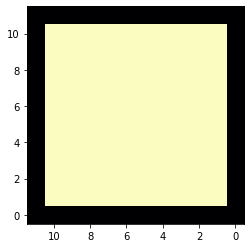

In [5]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(snapshots[0], "magma", vmin=-1, vmax=12, )

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

def init():
    im.set_data(snapshots[0])
    return (im, )

def animate(i: int):
    im.set_data(snapshots[i])
    return (im, )

print("Adding flashes")
flash = 12
for i, s in enumerate(snapshots):
    if i > 0:
        flashes = (s == 0).logical_and(snapshots[i - 1] != flash).logical_and(snapshots[i - 1] != 0)
        s[flashes] = flash

print("Animating")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(snapshots), interval=100, blit=True)

print("Converting")

# The fancy js version doesn't work in github,
# but when running locally, it's pretty nice:
# HTML(anim.to_jshtml())

HTML(anim.to_html5_video())
